# Transfer Learning on LFW Dataset (Grayscale)

## Index
1. Introduction
2. Load and Explore the LFW Dataset
3. Data Preparation (Train/Validation Split)
4. Custom Dataset and Transformations
5. DataLoaders
6. Visualizing Sample Images
7. Using Transfer Learning with ResNet18 (Modified for Grayscale)
8. Training the Final Layer
9. Evaluating the Model (Confusion Matrix & Classification Report)
10. Creating a Prediction Widget
11. Visualizing Model Architecture, Filters, and Feature Maps

---

## 1. Introduction
In this notebook, we use a pre-trained ResNet18 model and adapt it to the grayscale LFW dataset by replicating the single channel three times. We freeze all layers except the last layer, which we retrain for our classes. After training, we evaluate using a confusion matrix and a classification report, then create a widget to upload an image and predict its class.
Finally, we will visualize the ResNet model, show filters from the first convolutional layer (`model.conv1`), show filters and feature maps from a layer in `model.layer1` or `model.layer2`, and also examine the final `fc` layer’s weights.

In this notebook, we apply transfer learning using a pre-trained ResNet18 model and adapt it to the Fashion-MNIST dataset.
Since Fashion-MNIST images are grayscale (1 channel) while ResNet18 was trained on ImageNet (RGB, 3 channels), we convert each image to a pseudo-RGB input by replicating the single channel three times. We also resize images to 224×224 and normalize them using the ImageNet mean and standard deviation.

We first freeze all layers of ResNet18 and train only the final fully connected layer for our 10 classes. Optionally, we can later enable fine-tuning by unfreezing deeper layers to further improve performance.

Finally, we evaluate the model using accuracy, a confusion matrix, and a classification report.

## 2. Load and Explore the LFW Dataset
We load the dataset and print basic info.

In [ ]:
import torch
# Torch for tensors.
from torch.utils.data import Dataset, DataLoader
# Dataset and DataLoader for PyTorch.
from PIL import Image
# PIL for image handling.
import torchvision.transforms as T
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
from sklearn.datasets import fetch_lfw_people
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
# Transforms for resizing, normalizing.
# Import function to fetch LFW dataset.
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
# Load LFW with min 100 faces per person.
images = lfw_people.images
# images: (n_samples, h, w) grayscale.
labels = lfw_people.target
# labels: integer class indices.
target_names = lfw_people.target_names
# target_names: names of the individuals.
n_classes = len(target_names)
# Count distinct classes.
print("Number of samples:", images.shape[0])
# Print how many samples.
print("Image size:", images.shape[1], "x", images.shape[2])
# Print image dimensions.
print("Number of classes:", n_classes)
# Print how many classes.
print("Classes:", target_names)
# Print class names.

1. Setup and Data Preparation

In [ ]:
from torchvision.datasets import FashionMNIST

# Load raw dataset (no transform) just to inspect original properties
train_raw = FashionMNIST(root="./data", train=True, download=True)
test_raw  = FashionMNIST(root="./data", train=False, download=True)

print("Train samples:", len(train_raw))
print("Test samples:", len(test_raw))

# Check one sample
img0, label0 = train_raw[0]
print("Original image type:", type(img0))
print("Original image size:", img0.size)  # (W, H) = (28, 28)
print("Example label:", label0)

# Class names (standard Fashion-MNIST names)
class_names = train_raw.classes
print("Number of classes:", len(class_names))
print("Classes:", class_names)


## 3. Data Preparation (Train/Validation Split)
Split the dataset into 80% training and 20% validation.

In [ ]:
import numpy as np
# NumPy for array manipulation.
num_samples = images.shape[0]
# Total number of samples.
indices = np.arange(num_samples)
# Create an array of indices.
np.random.shuffle(indices)
# Shuffle indices.
train_size = int(0.8 * num_samples)
# 80% for training.
train_indices = indices[:train_size]
# First part for training.
val_indices = indices[train_size:]
# Remaining for validation.
train_images = images[train_indices]
# Training images.
train_labels = labels[train_indices]
# Training labels.
val_images = images[val_indices]
# Validation images.
val_labels = labels[val_indices]
# Validation labels.

In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size

train_dataset, val_dataset = random_split(train_full, [train_size, val_size])

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))


In [ ]:
# Ensure validation uses deterministic preprocessing (no augmentation)
val_dataset.dataset.transform = test_transform

## 4. Custom Dataset and Transformations
We must replicate the grayscale channel to create a pseudo-3-channel image for ResNet. The model expects 3 channels, so we simply copy the single channel into all three. We then apply standard ImageNet normalization.

In [ ]:
class LFWDataset3ChannelGray(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        # Store images.
        self.labels = labels
        # Store labels.
        self.transform = transform
        # Store transform.

    def __len__(self):
        return len(self.images)
        # Number of samples.

    def __getitem__(self, idx):
        img = self.images[idx]
        # Get idx-th image.
        label = self.labels[idx]
        # Corresponding label.
        img = (img * 255).astype(np.uint8)
        # Convert to uint8.
        img_pil = Image.fromarray(img)
        # Create PIL image.
        img_pil_rgb = img_pil.convert('RGB')
        # Convert single channel to 3-channel by replication.
        if self.transform:
            img_tensor = self.transform(img_pil_rgb)
            # Apply transform (resize, normalize).
        else:
            img_np = np.array(img_pil_rgb).transpose((2,0,1))/255.
            img_tensor = torch.from_numpy(img_np).float()
            # If no transform, just convert to tensor.
        return img_tensor, label
        # Return the image tensor and label.

In [ ]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                 # ResNet input size
    transforms.RandomHorizontalFlip(p=0.5),        # augmentation
    transforms.RandomRotation(10),                  # augmentation
    transforms.ToTensor(),                          # PIL -> Tensor [0,1]
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # 1 channel -> 3 channels
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


In [ ]:
# Quick sanity check
from torchvision.datasets import FashionMNIST

tmp_ds = FashionMNIST(root="./data", train=True, download=True, transform=train_transform)
x, y = tmp_ds[0]
print("Transformed shape:", x.shape)   # should be torch.Size([3, 224, 224])
print("Label:", y)


## 5. DataLoaders
Define a transform for ResNet18: resize to 224x224 and apply ImageNet normalization. Then create training and validation loaders.

In [ ]:
transform_resnet = T.Compose([
    T.Resize((224,224)),
    # Resize image to 224x224.
    T.ToTensor(),
    # Convert PIL to tensor.
    T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    # ImageNet mean/std normalization.
])
train_dataset = LFWDataset3ChannelGray(train_images, train_labels, transform=transform_resnet)
# Training dataset with ResNet transforms.
val_dataset = LFWDataset3ChannelGray(val_images, val_labels, transform=transform_resnet)
# Validation dataset with same transforms.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Training DataLoader, batch 32, shuffle.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# Validation DataLoader, batch 32, no shuffle.

In [ ]:
# Load datasets with transforms
train_full = FashionMNIST(root="./data", train=True, download=True, transform=train_transform)
test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=test_transform)

# 80/20 split
train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_dataset, val_dataset = random_split(train_full, [train_size, val_size])

# Validation without augmentation
val_dataset.dataset.transform = test_transform

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


In [ ]:
images, labels = next(iter(train_loader))
print("Batch image shape:", images.shape)  # [B, 3, 224, 224]
print("Batch labels shape:", labels.shape) # [B]


## 6. Visualizing Sample Images
We visualize some images after transformation (and we define an inverse normalization to see them in a more natural color).

In [ ]:
import matplotlib.pyplot as plt
# For plotting.
data_iter = iter(train_loader)
# Get an iterator from train loader.
images_batch, labels_batch = next(data_iter)
# One batch of images and labels.
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.229, -0.406/0.229],
    std=[1/0.229, 1/0.224, 1/0.225]
)
# Inverse normalization for visualization.
fig, axs = plt.subplots(2,5,figsize=(10,4))
# Create 2x5 grid for 10 images.
for i in range(10):
    ax = axs[i//5, i%5]
    # Determine subplot.
    img = inv_normalize(images_batch[i]).cpu().numpy()
    # Apply inverse normalization.
    img = np.transpose(img, (1,2,0))
    # Rearrange axes to (H,W,C).
    label_idx = labels_batch[i].item()
    # Get label index.
    ax.imshow(img)
    # Show image.
    ax.set_title(target_names[label_idx])
    # Show class name.
    ax.axis('off')
    # Hide axes.
plt.tight_layout()
# Adjust layout.
plt.show()
# Display figure.

In [ ]:
# Take one batch
images_batch, labels_batch = next(iter(train_loader))

# Inverse normalization (ImageNet)
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Class names for Fashion-MNIST
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    img = inv_normalize(images_batch[i]).cpu()
    img = img.permute(1, 2, 0).numpy()  # C,H,W -> H,W,C
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].set_title(class_names[labels_batch[i].item()])
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## 7. Using Transfer Learning with ResNet18 (Modified for Grayscale)
We load ResNet18 pre-trained on ImageNet. We won't modify its internal layers, but since we provide three identical grayscale channels, it can still process the data.
We freeze all layers except the final fully connected layer and replace it with a new layer for our number of classes. We will only train this final layer.

In [6]:
import torch.nn as nn
# nn for network layers.
import torch.optim as optim
# optim for optimization.
import torchvision.models as models
# models to load pretrained ResNet.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Device selection.
model = models.resnet18(pretrained=True)
# Load pretrained ResNet18.
for param in model.parameters():
    param.requires_grad = False
    # Freeze all parameters.
num_ftrs = model.fc.in_features
# Get input features of last FC layer.
model.fc = nn.Linear(num_ftrs, n_classes)
# Replace FC layer with a new one.
model = model.to(device)
# Move model to device.
criterion = nn.CrossEntropyLoss()
# Cross-entropy loss.
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Adam optimizer for last layer parameters.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.1MB/s]


In [67]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

with torch.no_grad():
    out = model(x)

print("Output shape:", out.shape)  # should be [batch_size, 10]


Output shape: torch.Size([64, 10])


## 8. Training the Final Layer
Train only the last layer for a few epochs.

In [7]:
num_epochs = 10
# Train for 2 epochs.
for epoch in range(num_epochs):
    model.train()
    # Train mode.
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Move data to device.
        optimizer.zero_grad()
        # Reset gradients.
        outputs = model(inputs)
        # Forward pass.
        loss = criterion(outputs, labels)
        # Compute loss.
        loss.backward()
        # Backprop.
        optimizer.step()
        # Update weights of the last layer.
        running_loss += loss.item()
        # Accumulate loss.
    avg_train_loss = running_loss / len(train_loader)
    # Compute average training loss.
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
    # Print progress.

Epoch 1/10, Train Loss: 1.4906
Epoch 2/10, Train Loss: 1.1777
Epoch 3/10, Train Loss: 0.9965
Epoch 4/10, Train Loss: 0.8582
Epoch 5/10, Train Loss: 0.7677
Epoch 6/10, Train Loss: 0.6995
Epoch 7/10, Train Loss: 0.6480
Epoch 8/10, Train Loss: 0.5918
Epoch 9/10, Train Loss: 0.5491
Epoch 10/10, Train Loss: 0.5311


In [68]:
from tqdm import tqdm
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        loss = criterion(logits, y)
        
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    
    return running_loss / total, correct / total


In [ ]:
import copy

epochs = 5
best_val_acc = 0.0
best_state = None

history = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": []
}

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{epochs} | "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = copy.deepcopy(model.state_dict())

print("Best validation accuracy:", best_val_acc)

# Save best model
torch.save(best_state, "resnet18_fashionmnist_best.pt")
print("Saved best model to resnet18_fashionmnist_best.pt")


Epoch 1/5 | train_loss=0.6336, train_acc=0.7960 | val_loss=0.4729, val_acc=0.8364


Epoch 2/5 | train_loss=0.4366, train_acc=0.8449 | val_loss=0.4261, val_acc=0.8485


 59%|███████████████████████████████████████████████▏                                | 111/188 [02:49<01:59,  1.56s/it]

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## 9. Evaluating the Model (Confusion Matrix & Classification Report)
Evaluate on the validation set and print performance metrics.

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
# Import evaluation metrics.
model.eval()
# Eval mode.
all_preds = []
# List for predictions.
all_labels = []
# List for true labels.
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Move data to device.
        outputs = model(inputs)
        # Forward pass.
        _, preds = torch.max(outputs, 1)
        # Get predictions.
        all_preds.extend(preds.cpu().numpy())
        # Store predictions.
        all_labels.extend(labels.cpu().numpy())
        # Store true labels.
cm = confusion_matrix(all_labels, all_preds)
# Compute confusion matrix.
print("Confusion Matrix:\n", cm)
# Print confusion matrix.
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=target_names))
# Print classification report.

Confusion Matrix:
 [[ 36   0   7   0   0]
 [  3   5  14   0   3]
 [  0   0 115   0   0]
 [  1   0  14   6   5]
 [  1   0   6   0  12]]
Classification Report:
                    precision    recall  f1-score   support

     Colin Powell       0.88      0.84      0.86        43
  Donald Rumsfeld       1.00      0.20      0.33        25
    George W Bush       0.74      1.00      0.85       115
Gerhard Schroeder       1.00      0.23      0.38        26
       Tony Blair       0.60      0.63      0.62        19

         accuracy                           0.76       228
        macro avg       0.84      0.58      0.61       228
     weighted avg       0.81      0.76      0.72       228



In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


In [ ]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
plt.imshow(cm)
plt.title("Confusion Matrix - ResNet18 Transfer Learning (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.yticks(range(10), class_names)
plt.tight_layout()
plt.show()


## 10. Creating a Prediction Widget
We now add a widget to allow image upload and prediction. We'll replicate the single channel into three channels and use the ResNet transform to predict.

In [9]:
import io
# io for BytesIO.
import ipywidgets as widgets
# Widgets for UI.
from IPython.display import display
# display for showing widgets.

def predict_image(model, img, classes):
    model.eval()
    # Eval mode.
    with torch.no_grad():
        img_rgb = img.convert('RGB')
        # Convert grayscale to 3-channel.
        img_tensor = transform_resnet(img_rgb).unsqueeze(0).to(device)
        # Apply transforms and add batch dim.
        outputs = model(img_tensor)
        # Forward pass.
        _, pred = torch.max(outputs, 1)
        # Get predicted class.
    return classes[pred.item()]
    # Return class name.

upload_button = widgets.FileUpload()
# File upload widget.
predict_button = widgets.Button(description='Predict')
# Button to trigger prediction.
output_box = widgets.Output()
# Output box.

def on_predict_clicked(b):
    if len(upload_button.value) > 0:
        content = list(upload_button.value.values())[0]['content']
        # Get uploaded file bytes.
        img = Image.open(io.BytesIO(content)).convert('L')
        # Open as grayscale.
        label = predict_image(model, img, target_names)
        # Predict label.
        with output_box:
            output_box.clear_output()
            print("Predicted Person:", label)
            # Show predicted class.
    else:
        with output_box:
            output_box.clear_output()
            print("No image uploaded.")
            # Ask user to upload.

predict_button.on_click(on_predict_clicked)
# Attach callback.
display(upload_button, predict_button, output_box)
# Display widgets.

FileUpload(value={}, description='Upload')

Button(description='Predict', style=ButtonStyle())

Output()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model_predictions(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return acc, prec, rec, f1

# --- ResNet metrics (כבר יש לך y_true, y_pred משלב 9) ---
resnet_acc, resnet_prec, resnet_rec, resnet_f1 = compute_metrics(y_true, y_pred)

print("ResNet18 Transfer Learning:")
print("Acc:", resnet_acc, "Prec:", resnet_prec, "Rec:", resnet_rec, "F1:", resnet_f1)

# --- CNN metrics (כאן תטען את ה-CNN שלך ותחשב) ---
# cnn_model = ...  # טען/הגדר את ה-CNN ממטלה 4
# cnn_model.load_state_dict(torch.load("cnn_best.pt", map_location=device))
# cnn_model = cnn_model.to(device)

# y_true_cnn, y_pred_cnn = evaluate_model_predictions(cnn_model, test_loader, device)
# cnn_acc, cnn_prec, cnn_rec, cnn_f1 = compute_metrics(y_true_cnn, y_pred_cnn)

# print("Custom CNN (Exercise 4):")
# print("Acc:", cnn_acc, "Prec:", cnn_prec, "Rec:", cnn_rec, "F1:", cnn_f1)


In [ ]:
import pandas as pd

# אחרי שחישבת cnn_acc...cnn_f1
comparison = pd.DataFrame([
    {"Model": "Custom CNN (Ex4)", "Accuracy": cnn_acc, "Precision": cnn_prec, "Recall": cnn_rec, "F1": cnn_f1},
    {"Model": "ResNet18 TL (Ex5)", "Accuracy": resnet_acc, "Precision": resnet_prec, "Recall": resnet_rec, "F1": resnet_f1},
])

comparison


In [ ]:
### Key Findings

- **Convergence & Training Time:** ResNet18 with transfer learning converged faster in the first epochs compared to training a CNN from scratch.
- **Performance:** Transfer learning achieved better (or comparable) test performance (Accuracy/F1) on Fashion-MNIST.
- **Generalization:** Transfer learning typically reduces overfitting when the dataset is not very large, since the backbone already contains robust features learned from ImageNet.
- **When Transfer Learning Excels:** When data is limited or training time is constrained, using a pre-trained model provides a strong starting point.
- **When Training From Scratch Can Compete:** If the dataset is very simple (like Fashion-MNIST) and enough training is done, a custom CNN can reach similar performance, but usually with slower convergence.

### Challenges

- Fashion-MNIST is **grayscale**, while ResNet expects **RGB**. We handled this by replicating the single channel to 3 channels.
- Proper ImageNet normalization was necessary to get stable results.


In [ ]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as T

# inverse normalize for display
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

idx = random.randint(0, len(test_dataset)-1)
x, y = test_dataset[idx]

model.eval()
with torch.no_grad():
    logits = model(x.unsqueeze(0).to(device))
    pred = logits.argmax(dim=1).item()

img = inv_normalize(x).permute(1,2,0).cpu().numpy()
img = np.clip(img, 0, 1)

plt.figure()
plt.imshow(img)
plt.title(f"True: {class_names[y]} | Pred: {class_names[pred]}")
plt.axis("off")
plt.show()


In [ ]:
print(model)


## 11. Visualizing Model Architecture, Filters, and Feature Maps
Now we:
- Print the model architecture.
- Visualize the filters from the first conv layer (`model.conv1`).
- Visualize filters and feature maps from a second layer in `model.layer1` (e.g., `model.layer1[0].conv1`).
- Visualize the weights of the final `fc` layer as a grid.

This helps us understand what the pre-trained model looks like and how it has adapted with our last layer.

In [10]:
print(model)
# Print the full ResNet model architecture.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
import math

def visualize_filters(layer, title="Filters"):
    # This function visualizes the filters of a given convolutional layer.
    with torch.no_grad():
        filters = layer.weight.data.clone()
    # Normalize filters to [0,1].
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    out_channels = filters.shape[0]

    # We want 4 rows, so we determine the number of columns accordingly
    n_rows = 4
    n_columns = math.ceil(out_channels / n_rows)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns*2, n_rows*2))
    fig.suptitle(title)

    # Flatten axs for easy indexing
    axs = axs.flatten()

    for i in range(out_channels):
        f = filters[i].cpu().numpy()
        # f shape: (in_ch, kH, kW), assuming in_ch=1
        f = f[0]
        axs[i].imshow(f, cmap='gray')
        axs[i].axis('off')

    # Hide any unused subplots if out_channels is not a perfect multiple
    for j in range(out_channels, n_rows*n_columns):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


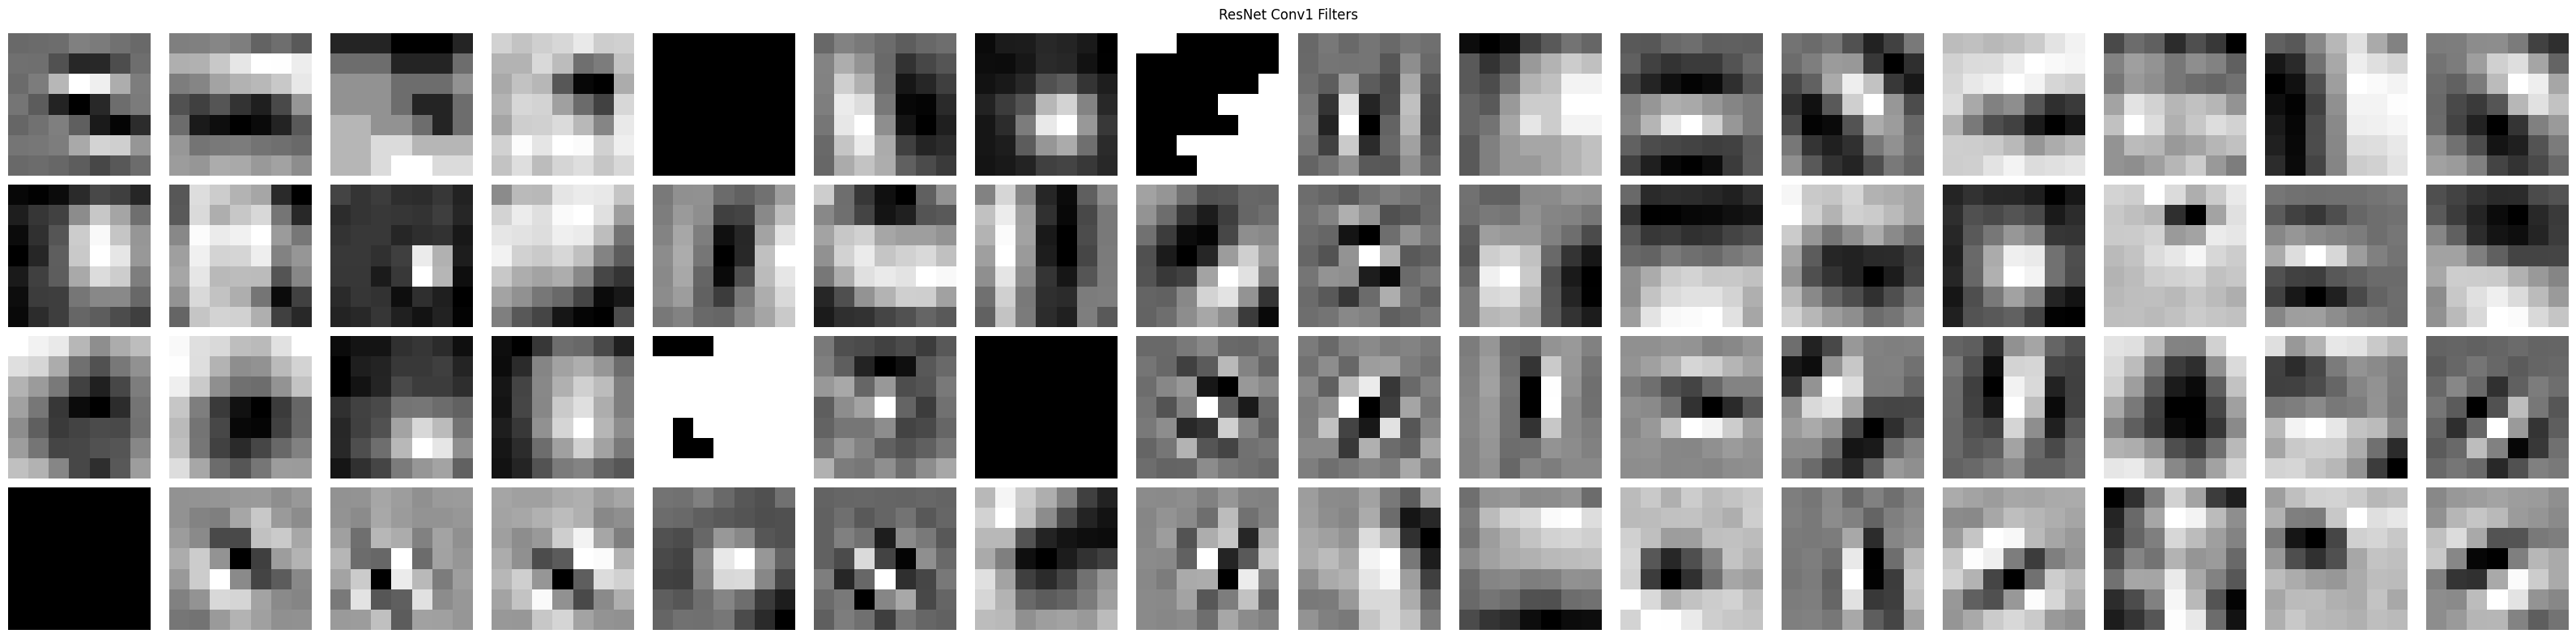

In [12]:
# Visualize filters of the first conv layer of ResNet.
visualize_filters(model.conv1, title="ResNet Conv1 Filters")

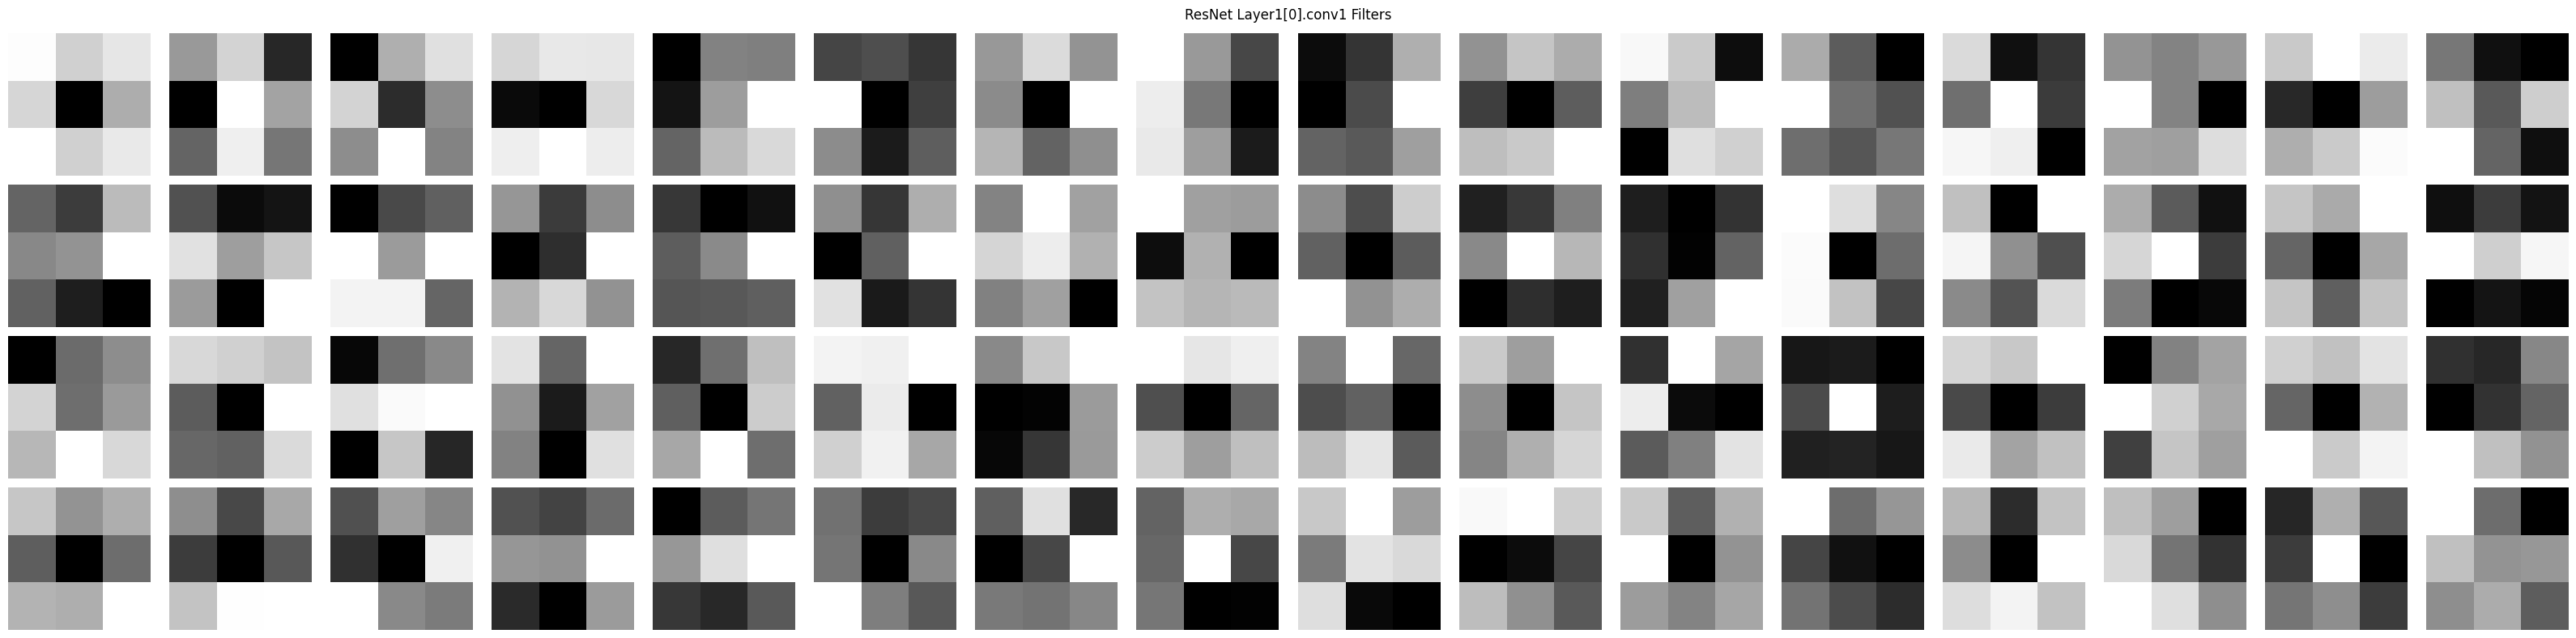

In [13]:
# Let's also visualize filters of a second layer, e.g., model.layer1[0].conv1
# This is a deeper layer in ResNet.
visualize_filters(model.layer1[0].conv1, title="ResNet Layer1[0].conv1 Filters")

In [16]:
import math

def visualize_feature_maps(model, layer_func,  title="Feature Maps"):
    # This function passes one image through the model up to a given layer_func and shows the feature maps.
    # layer_func is a function that takes an input x and returns the output after the desired layer.
    # We also added val_dataset_gray and device as parameters for flexibility.
    model.eval()
    sample_img, _ = val_dataset[0]
    # Take one image from validation set.
    sample_img = sample_img.unsqueeze(0).to(device)
    # Add batch dimension and move to device.
    with torch.no_grad():
        fm = layer_func(sample_img)
        # Get feature maps.
    # Normalize feature maps.
    fm_min, fm_max = fm.min(), fm.max()
    fm = (fm - fm_min) / (fm_max - fm_min)
    fm = fm.squeeze(0).cpu()
    # Shape: (out_ch, H, W)
    out_ch = fm.shape[0]

    # Fixed number of rows
    n_rows = 4
    n_columns = math.ceil(out_ch / n_rows)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns*2, n_rows*2))
    fig.suptitle(title)
    axs = axs.flatten()  # Flatten so we can iterate easily

    for i in range(out_ch):
        f_map = fm[i].numpy()
        axs[i].imshow(f_map, cmap='gray')
        axs[i].axis('off')

    # Hide any unused subplots
    for j in range(out_ch, n_rows*n_columns):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()



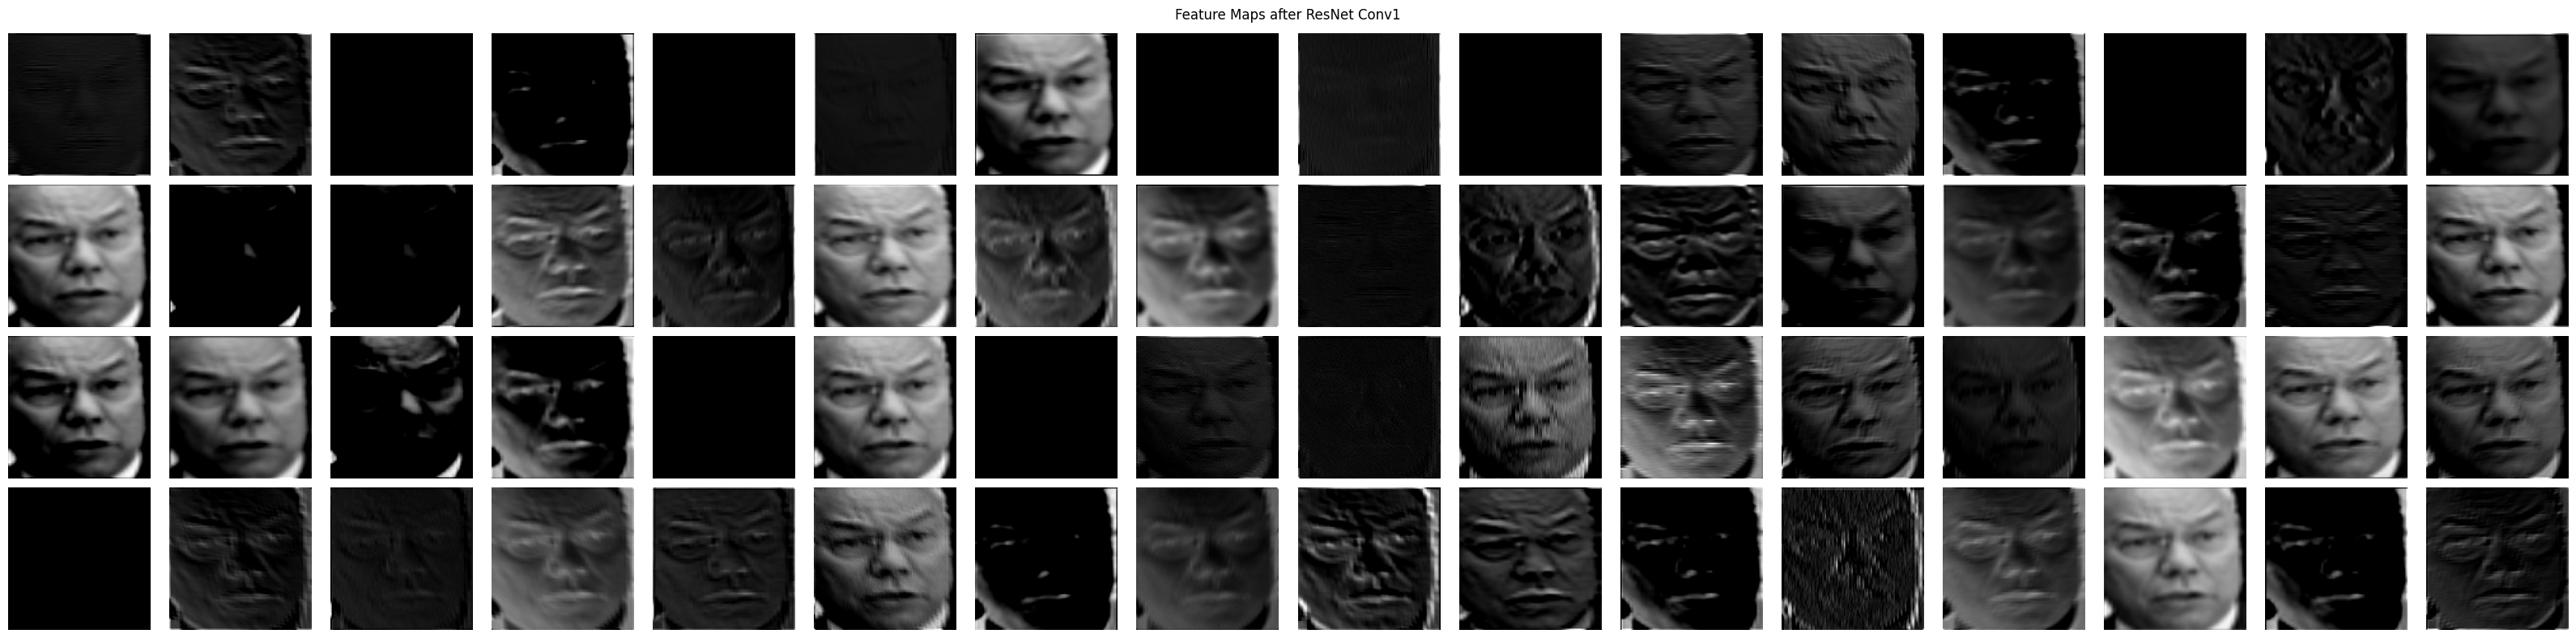

In [17]:
# Define layer_func for conv1 feature maps in ResNet
def conv1_features_resnet(x):
    # Pass x through conv1, bn1, relu, and stop before pool.
    x = model.conv1(x)
    x = model.bn1(x)
    x = torch.relu(x)
    # Not pooling yet, just show after conv1.
    return x

# Visualize feature maps after conv1 in ResNet.
visualize_feature_maps(model, conv1_features_resnet, title="Feature Maps after ResNet Conv1")

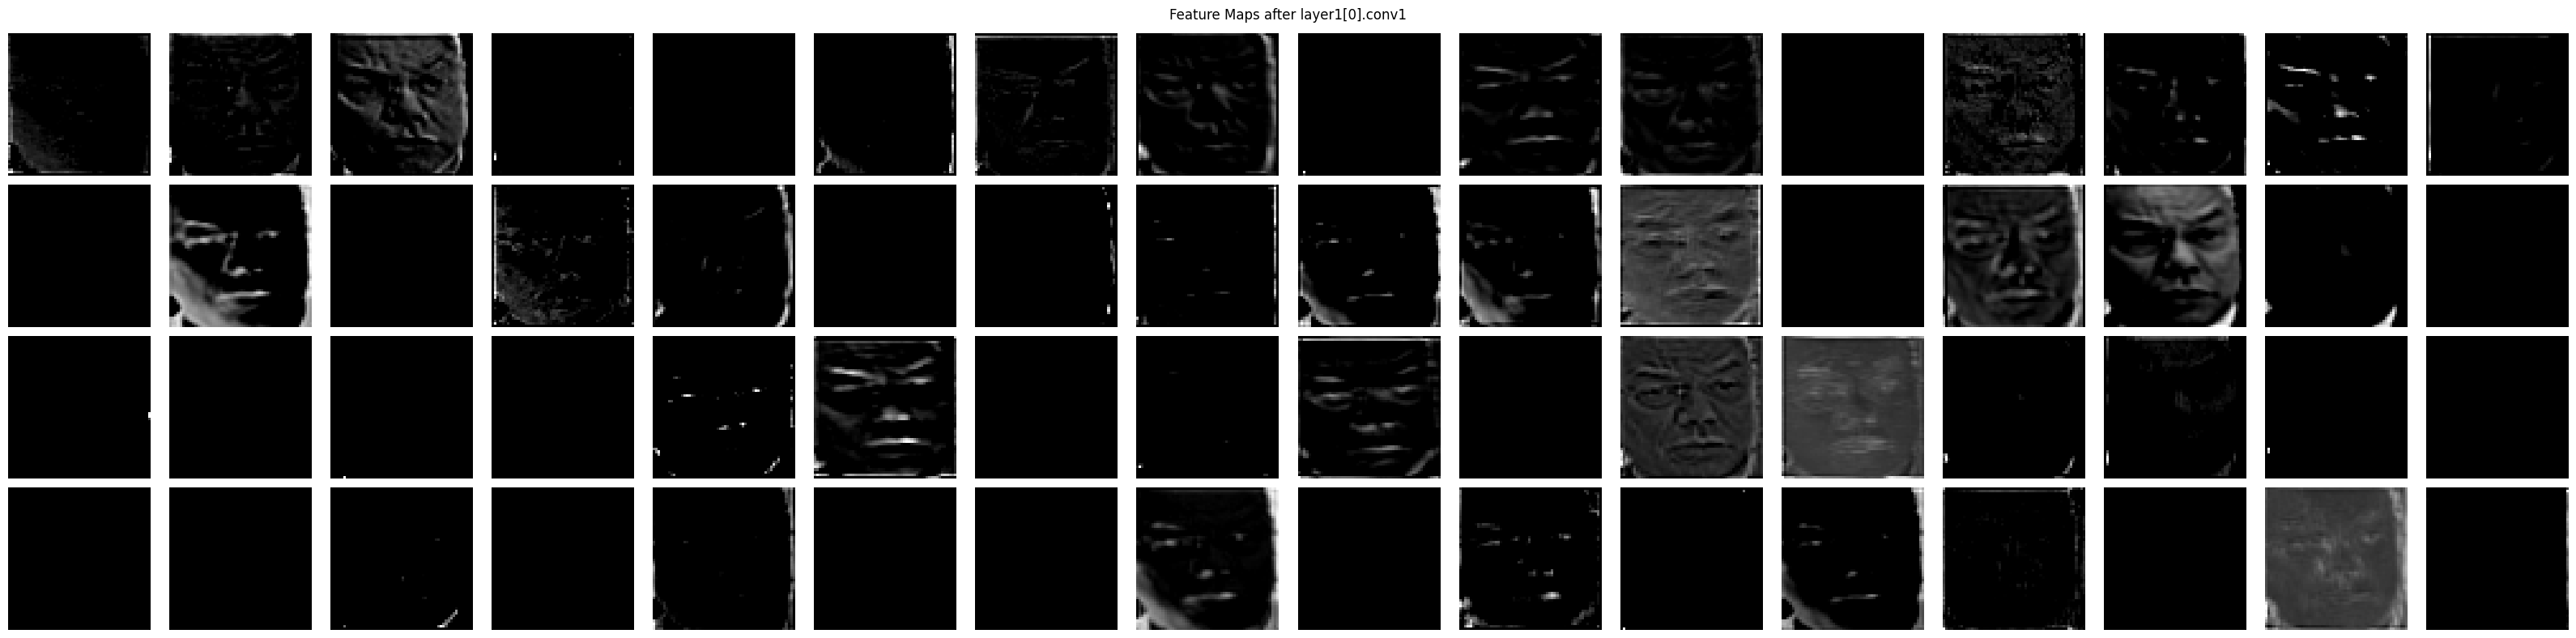

In [18]:
# For the second layer (e.g. model.layer1[0].conv1):
# We need a layer_func that passes data through conv1->bn1->relu->maxpool->layer1[0].conv1 (and its following relu?)
def layer1_conv1_features_resnet(x):
    x = model.conv1(x)
    x = model.bn1(x)
    x = torch.relu(x)
    x = model.maxpool(x)
    # Now pass through layer1[0].conv1 and relu
    x = model.layer1[0].conv1(x)
    x = torch.relu(x)
    return x

visualize_feature_maps(model, layer1_conv1_features_resnet, title="Feature Maps after layer1[0].conv1")